# Object Detection using OpenVino Pre-Trained Model

This notebook demonstrates how to do an object detection using one of OpenVino Pre-Trained Model. In this case, we will use the face detection model to detect faces on an image.

## The Libraries

We need 4 library to run this notebook. Those libraries include : 
- OpenCV (cv2) to load the image file, capture image from camera, and do other image processing techniques.
- Numpy to do an array opperation. 
- matplotlib to visualize the image on the notebook
- OpenVino to load the model and do the object detection using the model  

We need to make sure if those libraries have been installed in our computer. Run this code below to install the libraries.

In [ ]:
!pip install numpy

In [ ]:
!pip install openvino

In [ ]:
!pip install matplotlib

In [ ]:
!pip install opencv-python

## Import the libraries

In [1]:
#import library
from openvino.inference_engine import IECore
import cv2
import numpy as np
import matplotlib.pyplot as plt


D:\Python38\lib\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


## Load the model

In this step, we will load the model using the Inference Engine from OpenVino library. First, we create the inference engine core object (IECore) and then load the model. There are 2 files that which need to be loaded, the model architecture file (the .xml file) and its weight (the .bin file).

In [2]:
# initiate inference engine object
ie = IECore()

# load the network file
net = ie.read_network(
    model = 'face-detection-adas-0001.xml',
    weights = 'face-detection-adas-0001.bin'
)

# initiate the model based on the network and the device
# in this case, we will use CPU to do the inference
model = ie.load_network(net, "CPU")

D:\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Get Some Informations about the model

Each model has its own specification, so at this step we need to know some of the Informations such as
- the input label
- the output label
- the input size; and
- the input data type

In [3]:
print("Model input label     : ",model.input_info)
print("Model output label    : ",model.outputs)
print("Model input shape     : ", model.input_info['data'].tensor_desc.dims)
print("Model input data type : ",model.input_info['data'].precision)

Model input label     :  {'data': <openvino.inference_engine.ie_api.InputInfoCPtr object at 0x0000026CD811D390>}
Model output label    :  {'detection_out': <openvino.inference_engine.ie_api.CDataPtr object at 0x0000026CD811D490>}
Model input shape     :  [1, 3, 384, 672]
Model input data type :  FP32


In [4]:
input_key = list(model.input_info.keys())[0]
output_key = list(model.outputs.keys())[0]
print("Input key    : ",input_key)
print("Output key   : ",output_key)

Input key    :  data
Output key   :  detection_out


## Load the image

(612, 612, 3)


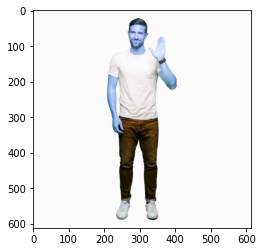

In [5]:
img = cv2.imread('person.jpg')
print(img.shape)
plt.imshow(img)

The loaded image may looks weird because the order of the color space is BGR. Let's leave it like that because the order of the color space in model input is expected to be BGR. We will convert the color after we do the inference.

## Process the Image

Before we do the inference, we need to make sure that the image shape is equal to the model input shape. The model input shape format is (B,C,H,W) which respectively represent :
- B --> Batch Size (number of processed data)
- C --> Number of image channel (mostly 3 for RGB Image / Colored Image)
- H --> Image Height
- W --> Image Width



First, we need to resize the image

In [6]:
# get the model input shape

B,C,H,W = model.input_info[input_key].tensor_desc.dims

resized = cv2.resize(img,(W,H))
resized.shape

(384, 672, 3)

The image shape still in format (H,W,C), so we need to reorder the format into (C,H,W) by applying np.transpose() function

In [7]:
transpose = np.transpose(resized,(2,0,1))
transpose.shape

(3, 384, 672)

We have reorder the image shape into (C,H,W) format. The model needs the input in a form of batched-array so we need to encapsulate the image in a form of new np.array. We also need to change the datatype into float32 because our model use FP32 as the input datatype.

In [8]:
input_image = np.array([transpose])
input_image.shape

(1, 3, 384, 672)

Here, You will see that both shapes are equal

In [9]:
print("Image shape       : ", input_image.shape)
print("Model input shape : ", model.input_info[input_key].tensor_desc.dims)

Image shape       :  (1, 3, 384, 672)
Model input shape :  [1, 3, 384, 672]


## Do the inference

To do the inference, we simply use the model.infer() function and set the parameter in a form of dictionary. 

In [10]:
result = model.infer({input_key:input_image})
result

{'detection_out': array([[[[0.        , 1.        , 0.9999999 , ..., 0.06410378,
           0.5151206 , 0.16812262],
          [0.        , 1.        , 0.02232669, ..., 0.05899334,
           0.8650804 , 0.9175797 ],
          [0.        , 1.        , 0.01736612, ..., 0.04014185,
           0.45200646, 0.93476546],
          ...,
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ],
          [0.        , 0.        , 0.        , ..., 0.        ,
           0.        , 0.        ]]]], dtype=float32)}

In [11]:
result[output_key].shape

(1, 1, 200, 7)

You will get an output in a form of dictionary too. The dictionary encapsulates the model output which is an array. The model output shape is in (1,1,N,7) format where N represents the number of detected object. Each detected object is represented by an array which has 7 elements. The description of those 7 elements are \[image_id, label, confidence, x_min, y_min, x_max, y_max\] where : 

- image_id --> image id in the batch (mostly 1)
- label --> image label
- confidence --> the confidence score of the detected image with a range from 0 to 1
- x_min, y_min --> the top left coordinates of the bounding box with a range from 0 to 1
- x_max, y_max --> the bottom right coordinates of the bounding box a range from 0 to 1

for example, let's see one of the detected object below

In [12]:
item_result = result['detection_out'][0][0][0]
item_result

array([0.        , 1.        , 0.9999999 , 0.44259897, 0.06410378,
       0.5151206 , 0.16812262], dtype=float32)

From that array we can get these following values :

In [13]:
print("image id     : ",item_result[0])
print("image label  : ",item_result[1])
print("confidence   : ",item_result[2])
print("x_min, y_min : ",(item_result[3],item_result[4]))
print("x_min, y_min : ",(item_result[5],item_result[6]))

image id     :  0.0
image label  :  1.0
confidence   :  0.9999999
x_min, y_min :  (0.44259897, 0.06410378)
x_min, y_min :  (0.5151206, 0.16812262)


## Draw the bounding box on image

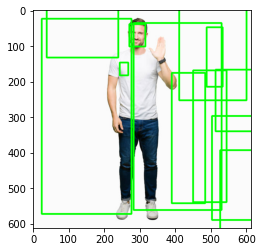

In [14]:
output_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
for i in result['detection_out'][0][0]:
    h,w,c  = output_img.shape
    cv2.rectangle(
        output_img,
        (int(i[3]*w),int(i[4]*h)),
        (int(i[5]*w),int(i[6]*h)),
        (0,255,0),3
    )

plt.imshow(output_img)

You can see that there are so many detected bounding box. We know that each bounding box has its own confindence value so we have to set the threshold value. Here, we will only draw the bounding box if the confindence value is greater than 0.9.

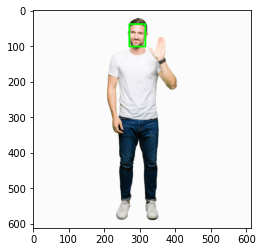

In [15]:
output_img = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2RGB)
for i in result['detection_out'][0][0]:
    h,w,c  = output_img.shape
    if i[2] > 0.9:
        cv2.rectangle(
            output_img,
            (int(i[3]*w),int(i[4]*h)),
            (int(i[5]*w),int(i[6]*h)),
            (0,255,0),3
        )

plt.imshow(output_img)

After we set the threshold value, only 1 bounding box which will be drawn and the bounding box shows us the detected face on the image.

## Try with other model

Intel OpenVino provides us with many open and ready-to-use pre-trained model. You can download the model (.xml and .bin file) at https://download.01.org/opencv/2021/openvinotoolkit/2021.2/open_model_zoo/models_bin/3/. After you click this link, you have to go to the model directory, select the model precision (FP16, FP32, INT8), then download the .xml and .bin model. Every model has its own detailed documentation at https://docs.openvinotoolkit.org/latest/object_detection_models_intel.html

Happy Experimenting!!